### Check on new formulas from Manish, date: 1/9/18

In [1]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from time import time


### import tables

In [3]:
def print_table(table):
    print(len(table), table.columns)
    

In [4]:
def import_tables(product, data_dir):
    product_dir = "".join([data_dir,product,'/'])

    invoice_date = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_DOC_KEY_DTLS_",product,".txt"]), sep = "|", low_memory=False)
#     print('invoice_date')
#     print_table(invoice_date)
    
    invoice_amount = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_DOC_PROC_DTLS_",product,".txt"]), sep = "|", low_memory=False)
#     print('invoice_amount')
#     print_table(invoice_amount)
    
    deal_hist = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_DEAL_HIST_",product,".txt"]), sep = "|", low_memory=False)
#     print('deal_hist')
#     print_table(deal_hist)
    
    rff = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_RFF_ALLOC_DTLS_",product,".txt"]), sep = "|", low_memory=False)
    rff['fin_ccy_amt'] =  rff.fin_ccy_cp_alloc_amt  + rff.fin_ccy_ncp_alloc_amt  
#     print('rff')
#     print_table(rff)
    
    rff_dtls = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_RFF_DTLS_",product,".txt"]), sep = "|", low_memory=False)
#     print('rff_dtls')
#     print_table(rff_dtls)
    
    pymt = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_PYMT_ALLOC_DTLS_",product,".txt"]), sep = "|", low_memory=False)
    pymt['pymt_ccy_amt'] = pymt.fin_ccy_cp_liq_amt  + pymt.fin_ccy_ncp_liq_amt   +  pymt.pymt_ccy_cp_adj_amt  + pymt.pymt_ccy_ncp_adj_amt  
#     print('pymt')
#     print_table(pymt)

    if product == 'RSRV':
        invoice_detail = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_DOC_ADDL_DTLS_",product,"1.csv"]), low_memory=False)
        pymt_dtls = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_PYMT_DTLS_",product,".csv"]), low_memory=False)
    else: 
        invoice_detail = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_DOC_ADDL_DTLS_",product,".txt"]), sep = "|", low_memory=False)
        pymt_dtls = pd.read_csv("".join([product_dir, "OTP_ALL_SCBT_T_PYMT_DTLS_",product,".txt"]), sep = "|", low_memory=False)
#     print('invoice_detail')
#     print_table(invoice_detail)
#     print('pymt_dtls')
#     print_table(pymt_dtls)

    return invoice_date,invoice_amount,deal_hist,rff,pymt,invoice_detail, rff_dtls, pymt_dtls

### convert to usd

In [5]:
# # new x_rate file from Google
# update through google sheets: 
#     =GOOGLEFINANCE("inrusd","price",date(2017,1,1),date(2017,11,30))


def load_x_rate(x_rate_csv):

    x_rate = pd.read_csv(x_rate_csv)
    x_rate['date_stamp']=[pd.Timestamp(x) for x in x_rate.Date]
    x_rate['yr_mo'] = [str(x)[:7] for x in x_rate.date_stamp]
    x_rate = x_rate.groupby(['CCY','yr_mo']).agg({'Rate':np.mean})
    x_rate.reset_index(level=['CCY','yr_mo'], inplace=True)
    return x_rate

In [6]:
#convert amounts to usd
def covert_to_usd(table):
    #input table columns: ccy code, date, amt
    table.columns = ['CCY','Date', 'amt']
    table['date_stamp']=[pd.Timestamp(x) for x in table.Date]
    table['yr_mo'] = [str(x)[:7] for x in table.date_stamp]
#     table['yr_mo'] = [x[:7] for x in table.Date]
    table = table.merge(x_rate, how = 'left', on = ['CCY','yr_mo'])
    table['Rate'] = np.where(table.CCY == 'USD',1., table.Rate)
#     table['amt_usd'] = table.amt/table.Rate
    
    return table.Rate


In [7]:

x_rate_csv = '/home/ec2-user/SCB_CODE/cam_code/daily_x_rate.csv'
x_rate = load_x_rate(x_rate_csv)

In [8]:
x_rate.tail()

,CCY,yr_mo,Rate
3037,ZAR,2017-07,0.076194
3038,ZAR,2017-08,0.075522
3039,ZAR,2017-09,0.075996
3040,ZAR,2017-10,0.073013
3041,ZAR,2017-11,0.071004


In [9]:
# products = ['BATB', 'BDBR', 'ECIF', 'ECPR', 'IFNB', 'IFNS', 'LBDS', 'LRRP', 'PSHP', 'TRDS', 'RSRV']
# products = [ 'ECIF', 'ECPR', 'IFNB', 'IFNS', 'LBDS', 'LRRP', 'PSHP', 'TRDS', 'RSRV']
product = "RSRV"
data_dir = '/home/ec2-user/SCB_DATA/FROM_SCB_TXT/'

In [10]:
s= time()
    #merge doc data
invoice_date,invoice_amount,deal_hist,rff,pymt,invoice_detail, rff_dtls, pymt_dtls = import_tables(product, data_dir)
inv_det = inv_det = invoice_date[[
        'cty_code', 'rec_id', 'deal_rec_id', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'doc_date', 'deal_id'
    ]].merge(invoice_amount[[
        'rec_id', 'doc_id', 'doc_ccy_code', 'doc_ccy_amt', 'fin_flag']], 
                                    how= 'inner', on = ['doc_id', 'rec_id']).merge(invoice_detail[[
        'rec_id', 'doc_id', 'tenor', 'tenor_start_date', 'due_date', 'grace_period', 'maturity_date', 
        'fin_tenor_start_date', 'fin_tenor', 'to_seq_no', 'from_seq_no']], how= 'inner', on = ['doc_id', 'rec_id'])

len(inv_det), inv_det.columns

(846969,
 Index([u'cty_code', u'rec_id', u'deal_rec_id', u'doc_id', u'supplier_id',
        u'buyer_id', u'doc_type_code', u'doc_date', u'deal_id', u'doc_ccy_code',
        u'doc_ccy_amt', u'fin_flag', u'tenor', u'tenor_start_date', u'due_date',
        u'grace_period', u'maturity_date', u'fin_tenor_start_date',
        u'fin_tenor', u'to_seq_no', u'from_seq_no'],
       dtype='object'))

In [11]:
inv_det_doc = inv_det.groupby(['cty_code', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'deal_id', 'fin_flag']).agg({'rec_id':'max'})
inv_det_doc.reset_index(level = ['cty_code', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'deal_id', 'fin_flag'], inplace = True)
len(inv_det_doc), len(pd.unique(inv_det_doc.doc_id))
inv_det_doc = inv_det_doc.merge(inv_det, how = 'left', on =['cty_code', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'deal_id', 'fin_flag', 'rec_id'])
len(inv_det_doc), len(pd.unique(inv_det_doc.doc_id))

(820920, 820864)

In [12]:
#settled_deal_hist
# Deal Hist.Sale_Ledger_Flag = “Y” and Deal_Hist. pool_based_flag = “N” and Deal Hist.Step_Code = “SETT”
settled_deal_hist = deal_hist[(deal_hist.sale_ledger_flag=='Y')
                             &(deal_hist.pool_based_flag=='N')
                              &(deal_hist.step_code=='SETT')
                             ][['sale_ledger_flag','pool_based_flag','step_code','deal_id',
                                'product_variant_code', 'rel_seq_no', 'value_date']]
settled_deal_hist.drop_duplicates(inplace = True)
len(settled_deal_hist)

206236

In [13]:
#settled_deal_hist
# Deal Hist.Sale_Ledger_Flag = “Y” and Deal_Hist. pool_based_flag = “N” and Deal Hist.Step_Code = “SETT”
settled_deal_hist_all = deal_hist[
#     (deal_hist.sale_ledger_flag=='Y')
#                              &(deal_hist.pool_based_flag=='N')
#                               &
    (deal_hist.step_code=='SETT')
                             ][['sale_ledger_flag','pool_based_flag','step_code','deal_id',
                                'product_variant_code', 'rel_seq_no', 'value_date']]
settled_deal_hist_all.drop_duplicates(inplace = True)
len(settled_deal_hist_all)

652124

In [ ]:
settled_doc = inv_det_doc.merge(settled_deal_hist, how = 'inner', left_on = ['deal_id', 'to_seq_no'], 
                                    right_on=['deal_id', 'rel_seq_no'])
len(settled_doc)
len(pd.unique(settled_doc.doc_id))

In [14]:
settled_doc_all = inv_det_doc.merge(settled_deal_hist_all, how = 'inner', left_on = ['deal_id', 'to_seq_no'], 
                                    right_on=['deal_id', 'rel_seq_no'])
len(settled_doc_all)
len(pd.unique(settled_doc_all.doc_id))

585727

In [ ]:
settled_deal_hist_pool = deal_hist[
#     (deal_hist.sale_ledger_flag=='N')
#                              &
    (deal_hist.pool_based_flag=='Y')
                              &(deal_hist.step_code=='SETT')
                             ][['sale_ledger_flag','pool_based_flag','step_code','deal_id',
                                'product_variant_code', 'rel_seq_no', 'value_date']]
settled_deal_hist_pool.drop_duplicates(inplace = True)
len(settled_deal_hist_pool)

In [ ]:
settled_doc_pool = inv_det_doc.merge(settled_deal_hist_pool, how = 'inner', left_on = ['deal_id', 'to_seq_no'], 
                                    right_on=['deal_id', 'rel_seq_no'])
len(settled_doc_pool)
len(pd.unique(settled_doc_pool.doc_id))

In [ ]:
settled_doc['pooled'] = 'N'
settled_doc_pool['pooled'] = 'Y'

In [ ]:
RSRV_doc = settled_doc.append(settled_doc_pool, ignore_index=True)
RSRV_doc.tail()

In [15]:
RSRV_all = settled_doc_all
RSRV_all.tail()

,cty_code,doc_id,supplier_id,buyer_id,doc_type_code,deal_id,fin_flag,rec_id,deal_rec_id,doc_date,...,fin_tenor_start_date,fin_tenor,to_seq_no,from_seq_no,sale_ledger_flag,pool_based_flag,step_code,product_variant_code,rel_seq_no,value_date
585921,ZA,ZS73DCJZYG-92962,100231393,100232949.0,INV,TF227R0024,Y,316934776,TF227R0024-02639,2011-04-17 00:00:00,...,4/17/11 0:00,44.0,2447.0,1542,Y,N,SETT,RSRV01,2447.0,2011-05-31 00:00:00
585922,ZA,ZY9K2FHL5K-32037,100032605,100038176.0,INV,TF227R0025,Y,284117113,TF227R0025-00897,2012-11-28 00:00:00,...,11/28/12 0:00,64.0,884.0,838,Y,N,SETT,RSRV01,884.0,2013-01-31 00:00:00
585923,ZA,ZY9K2FHL5K-32038,100032605,100038176.0,INV,TF227R0025,Y,284117115,TF227R0025-00897,2012-11-28 00:00:00,...,11/28/12 0:00,64.0,884.0,838,Y,N,SETT,RSRV01,884.0,2013-01-31 00:00:00
585924,ZA,ZY9K2FHL5K-32039,100032605,100038176.0,INV,TF227R0025,Y,284117117,TF227R0025-00897,2012-11-28 00:00:00,...,11/28/12 0:00,64.0,884.0,838,Y,N,SETT,RSRV01,884.0,2013-01-31 00:00:00
585925,ZA,ZY9K2FHL5K-32040,100032605,100038176.0,INV,TF227R0025,Y,284117119,TF227R0025-00897,2012-11-28 00:00:00,...,11/28/12 0:00,64.0,884.0,838,Y,N,SETT,RSRV01,884.0,2013-01-31 00:00:00


In [16]:
table = RSRV_doc[['doc_ccy_code', 'doc_date', 'doc_ccy_amt']]
RSRV_doc['doc_xrate'] = covert_to_usd(table)

NameError: name 'RSRV_doc' is not defined

In [17]:
table = RSRV_all[['doc_ccy_code', 'doc_date', 'doc_ccy_amt']]
RSRV_all['doc_xrate'] = covert_to_usd(table)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
RSRV_all['doc_usd_amt'] = RSRV_all.doc_ccy_amt*RSRV_all.doc_xrate
RSRV_all.describe()

,supplier_id,buyer_id,doc_ccy_amt,tenor,grace_period,fin_tenor,to_seq_no,from_seq_no,rel_seq_no,doc_xrate,doc_usd_amt
count,5.859260e+05,5.859260e+05,5.859260e+05,585926.000000,585926.000000,585610.000000,585343.000000,585926.000000,585343.000000,585828.000000,5.858280e+05
mean,1.001603e+08,1.001718e+08,1.096247e+06,64.932606,36.743869,107.596486,5651.860724,5160.749917,5651.860724,0.686715,2.694789e+04
std,1.199073e+05,1.051566e+06,1.040001e+07,81.484612,50.792417,90.427351,11699.073470,11266.638002,11699.073470,0.427442,5.443253e+05
min,1.000007e+08,1.000000e+08,1.000000e-02,-336.000000,-14.000000,-5926.000000,1.000000,1.000000,1.000000,0.000069,1.476843e-04
25%,1.000326e+08,1.000382e+08,4.400000e+02,30.000000,0.000000,72.000000,824.000000,532.000000,824.000000,0.128942,2.637847e+02
50%,1.001215e+08,1.001983e+08,3.980400e+03,60.000000,2.000000,91.000000,2342.000000,1900.000000,2342.000000,1.000000,1.202003e+03
75%,1.002732e+08,1.002702e+08,3.076833e+04,90.000000,60.000000,120.000000,5210.000000,4752.000000,5210.000000,1.000000,8.100615e+03
max,1.004108e+08,9.000004e+08,1.391859e+09,2886.000000,915.000000,2886.000000,137431.000000,136567.000000,137431.000000,1.798441,1.031472e+08


In [ ]:
len(RSRV_doc.doc_id)

In [ ]:
RSRV_doc.groupby(['fin_flag','pool_based_flag', 'sale_ledger_flag' ]).agg({'doc_usd_amt':'sum', 'doc_id':'count'})

In [19]:
RSRV_all.groupby(['fin_flag','pool_based_flag', 'sale_ledger_flag' ]).agg({'doc_usd_amt':'sum', 'doc_id':'count'})

doc_id   doc_usd_amt
fin_flag pool_based_flag sale_ledger_flag                      
N        N               Y                  19174  7.457762e+08
         Y               Y                 337204  1.109227e+10
Y        N               Y                 229525  3.941464e+09

In [20]:
RSRV_all.columns

Index([u'cty_code', u'doc_id', u'supplier_id', u'buyer_id', u'doc_type_code',
       u'deal_id', u'fin_flag', u'rec_id', u'deal_rec_id', u'doc_date',
       u'doc_ccy_code', u'doc_ccy_amt', u'tenor', u'tenor_start_date',
       u'due_date', u'grace_period', u'maturity_date', u'fin_tenor_start_date',
       u'fin_tenor', u'to_seq_no', u'from_seq_no', u'sale_ledger_flag',
       u'pool_based_flag', u'step_code', u'product_variant_code',
       u'rel_seq_no', u'value_date', u'doc_xrate', u'doc_usd_amt'],
      dtype='object')

In [21]:
doc_date = []
for i in range(len(RSRV_all)):
    try:
        doc_date.append(pd.Timestamp(RSRV_all.doc_date[i]))
    except:
        doc_date.append(pd.Timestamp('2017-11-30'))

In [22]:
doc_year = [x.year for x in doc_date]
doc_yrmo = [(x.year*100)+x.month for x in doc_date]

In [ ]:
doc_date[i].year

In [23]:
RSRV_all['doc_date'] = doc_date
RSRV_all['doc_year'] = doc_year
RSRV_all['doc_yrmo'] = doc_yrmo

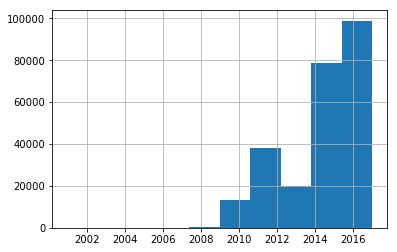

In [24]:
RSRV_all[RSRV_all.pool_based_flag == 'N'].doc_year.hist(); 

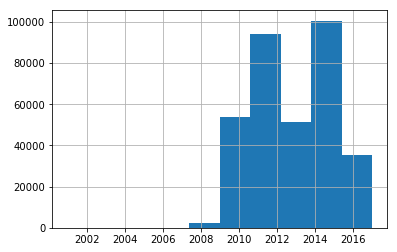

In [25]:
RSRV_all[RSRV_all.pool_based_flag == 'Y'].doc_year.hist(); 

In [26]:
RSRV_all.groupby(['fin_flag','pool_based_flag', 'sale_ledger_flag', 'doc_year','doc_yrmo' ]).agg({'doc_usd_amt':'sum', 'doc_id':'count'})

doc_id  \
fin_flag pool_based_flag sale_ledger_flag doc_year doc_yrmo           
N        N               Y                2001     200104         1   
                                          2008     200801        15   
                                                   200802        30   
                                                   200803        23   
                                                   200804        34   
                                                   200805        15   
                                                   200806         4   
                                          2009     200901         1   
                                                   200902         2   
                                                   200903        11   
                                                   200904         4   
                                                   200905         7   
                                                   200906         6   
                                                   200907        11   
                                                   200908         6   
                                                   200909        10   
                                                   200910        17   
                                                   200911        20   
                                                   200912        54   
                                          2010     201001        28   
                                                   201002        50   
                                                   201003        58   
                                                   201004        77   
                                                   201005       109   
                                                   201006       202   
                                                   201007       158   
                                                   201008       103   
                                                   201009       115   
                                                   201010       107   
                                                   201011       160   
...                                                             ...   
Y        N               Y                2015     201504      3334   
                                                   201505      3010   
                                                   201506      4771   
                                                   201507      3563   
                                                   201508      4309   
                                                   201509      5092   
                                                   201510      3576   
                                                   201511      4428   
                                                   201512      4848   
                                          2016     201601      3623   
                                                   201602      3479   
                                                   201603      5138   
                                                   201604      3602   
                                                   201605      4630   
                                                   201606      5312   
                                                   201607      4495   
                                                   201608      4936   
                                                   201609      5206   
                                                   201610      3842   
                                                   201611      7609   
                                                   201612      6509   
                                          2017     201701      5561   
                                                   201702      5038   
                                                   201703      5236   
              

In [27]:
RSRV_summary = RSRV_all.groupby(['fin_flag','pool_based_flag', 'sale_ledger_flag', 'doc_year','doc_yrmo' ]).agg({'doc_usd_amt':'sum', 'doc_id':'count'})
RSRV_summary.reset_index(level = ['fin_flag','pool_based_flag', 'sale_ledger_flag', 'doc_year','doc_yrmo' ], inplace = True)
RSRV_summary.to_csv('RSRV_summary.csv', index= False)

In [28]:
RSRV_summary.tail()

,fin_flag,pool_based_flag,sale_ledger_flag,doc_year,doc_yrmo,doc_id,doc_usd_amt
347,Y,N,Y,2017,201705,5315,7.393589e+07
348,Y,N,Y,2017,201706,5022,7.299965e+07
349,Y,N,Y,2017,201707,2833,5.933758e+07
350,Y,N,Y,2017,201708,2005,3.303496e+07
351,Y,N,Y,2017,201709,149,5.264611e+06


In [ ]:
products = ['RSRV']
for product in products:
    invoice_date,invoice_amount,deal_hist,rff,pymt,invoice_detail, rff_dtls, pymt_dtls = import_tables(product, data_dir)

    s= time()
    #merge doc data
    inv_det = inv_det = invoice_date[[
            'cty_code', 'rec_id', 'deal_rec_id', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'doc_date', 'deal_id'
        ]].merge(invoice_amount[[
            'rec_id', 'doc_id', 'doc_ccy_code', 'doc_ccy_amt', 'fin_flag']], 
                                        how= 'inner', on = ['doc_id', 'rec_id']).merge(invoice_detail[[
            'rec_id', 'doc_id', 'tenor', 'tenor_start_date', 'due_date', 'grace_period', 'maturity_date', 
            'fin_tenor_start_date', 'fin_tenor', 'to_seq_no', 'from_seq_no']], how= 'inner', on = ['doc_id', 'rec_id'])

    len(inv_det), inv_det.columns

    inv_det_doc = inv_det.groupby(['cty_code', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'deal_id', 'fin_flag']).agg({'rec_id':'max'})
    inv_det_doc.reset_index(level = ['cty_code', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'deal_id', 'fin_flag'], inplace = True)
    len(inv_det_doc), len(pd.unique(inv_det_doc.doc_id))
    inv_det_doc = inv_det_doc.merge(inv_det, how = 'left', on =['cty_code', 'doc_id', 'supplier_id', 'buyer_id', 'doc_type_code', 'deal_id', 'fin_flag', 'rec_id'])
    len(inv_det_doc), len(pd.unique(inv_det_doc.doc_id))

    #rff data
    rff_lookup = rff.groupby('doc_id').agg({'deal_rec_id':'max'})
    rff_lookup.reset_index(level = 'doc_id', inplace = True)
    len(rff_lookup),rff_lookup.head()

    rff_dedup_amt = rff_lookup.merge(rff[['doc_id', 'deal_rec_id','fin_ccy_code', 'fin_ccy_cp_alloc_amt', 'fin_ccy_ncp_alloc_amt',
                                   'fin_ccy_ncp_os_amt', 'fin_ccy_cp_os_amt']] , on = ['doc_id', 'deal_rec_id'], how = 'inner')
    len(rff_dedup_amt),len(rff_lookup)

    # Financed amount : fin_ccy_cp_alloc_amt + fin_ccy_ncp_alloc_amt
    # Outstanding : fin_ccy_ncp_os_amt + fin_ccy_cp_os_amt

    rff_dedup_amt['fin_ccy_amt'] = rff_dedup_amt.fin_ccy_cp_alloc_amt + rff_dedup_amt.fin_ccy_ncp_alloc_amt
    rff_dedup_amt['os_ccy_amt'] = rff_dedup_amt.fin_ccy_ncp_os_amt + rff_dedup_amt.fin_ccy_cp_os_amt
    rff_dedup_amt['pymt_ccy_amt']=rff_dedup_amt.fin_ccy_amt - rff_dedup_amt.os_ccy_amt
    rff_dedup_amt['dr'] = rff_dedup_amt.os_ccy_amt / rff_dedup_amt.fin_ccy_amt
    rff_dedup_amt.describe()
    rff_dedup_amt.dr.hist();

    print(len(rff_dedup_amt))
    rff_dedup_amt = rff_dedup_amt.merge(rff_dtls[['deal_rec_id','start_date']], on = 'deal_rec_id', how = 'inner')
    len(rff_dedup_amt)

    inv_det_doc_rff = inv_det_doc.merge(rff_dedup_amt, how = 'inner', on = 'doc_id')
    print(len(inv_det_doc), len(rff_dedup_amt), len(inv_det_doc_rff))
    inv_det_doc_rff.describe()

    #settled_deal_hist
    # Deal Hist.Sale_Ledger_Flag = “Y” and Deal_Hist. pool_based_flag = “N” and Deal Hist.Step_Code = “SETT”
    settled_deal_hist = deal_hist[
#         (deal_hist.sale_ledger_flag=='Y')
#                                  &(deal_hist.pool_based_flag=='N')
#                                   &
        (deal_hist.step_code=='SETT')
                                 ][['sale_ledger_flag','pool_based_flag','step_code','deal_id',
                                    'product_variant_code', 'rel_seq_no', 'value_date']]
    settled_deal_hist.drop_duplicates(inplace = True)
    len(settled_deal_hist)

    # Deal Hist.Deal_ID = Doc Addt Details.Deal_ID and Deal Hist.Rel_Seq_No = Doc Addt Details.To_Seq_No
    settled_doc = inv_det_doc_rff.merge(settled_deal_hist, how = 'inner', left_on = ['deal_id', 'to_seq_no'], 
                                        right_on=['deal_id', 'rel_seq_no'])
    len(settled_doc)
    len(pd.unique(settled_doc.doc_id))

    # unsettled_doc
    # Deal Hist.Sale_Ledger_Flag = “Y” and Deal_Hist. pool_based_flag = “N” And Deal Hist.Step_Code IN (‘NEW’, ‘RFF’)
    # And Deal Hist.Deal_ID = Doc Addt Details.Deal_ID And Doc Addt Details.To_Seq_No = null
    unsettled_deal_hist = deal_hist[(deal_hist.sale_ledger_flag=='Y')
                                 &(deal_hist.pool_based_flag=='N')
                                  &(deal_hist.step_code.isin(['NEW','RFF']))
                                 ][['sale_ledger_flag','pool_based_flag','step_code','deal_id', 
                                    'product_variant_code', 'value_date']]
    unsettled_deal_hist.drop_duplicates(inplace = True)
    len(unsettled_deal_hist)
    unsettled_deal_hist = unsettled_deal_hist.groupby(['sale_ledger_flag','pool_based_flag','deal_id', 
                                    'product_variant_code']).agg({'value_date':'max', 'step_code':'max'})
    unsettled_deal_hist.reset_index(level = ['sale_ledger_flag','pool_based_flag','deal_id', 
                                    'product_variant_code'], inplace = True)
    len(unsettled_deal_hist)
    # Deal Hist.Deal_ID = Doc Addt Details.Deal_ID and Deal Hist.Rel_Seq_No = Doc Addt Details.To_Seq_No
    unsettled_doc = inv_det_doc_rff.merge(unsettled_deal_hist, how = 'inner', on = 'deal_id')
    unsettled_doc = unsettled_doc[pd.isnull(unsettled_doc.to_seq_no)==True]
    unsettled_doc['rel_seq_no'] = None
    len(unsettled_doc)

    # Deal Hist.Deal_ID = Doc Addt Details.Deal_ID and Doc Addt Details.To_Seq_No is null
    unsettled_doc = inv_det_doc_rff.merge(unsettled_deal_hist, how = 'inner', on = 'deal_id')
    unsettled_doc = unsettled_doc[pd.isnull(unsettled_doc.to_seq_no)==True]
    unsettled_doc['rel_seq_no'] = None
    len(unsettled_doc)

    #merge settled and unsettled data
    settled_doc['settled_flag'] = 'Y'
    unsettled_doc['settled_flag'] = 'N'
    unsettled_doc = unsettled_doc[list(settled_doc.columns)]
    data_rec_id = settled_doc.append(unsettled_doc, ignore_index=True)
    len(data_rec_id), data_rec_id.dr.hist()

    data_rec_id.groupby(['fin_flag', 'settled_flag']).agg({'doc_id':'count'})

    data_rec_id.drop(['deal_rec_id_y', 'deal_rec_id_x'],axis = 1, inplace=True)
    data_rec_id.drop_duplicates(inplace=True)
    len(data_rec_id), len(pd.unique(data_rec_id.doc_id))

    data_rec_id.rename({'start_date':'fin_date', 'value_date':'pymt_date',}, axis=1, inplace = True)
    data_rec_id.columns

    data_doc = data_rec_id

    # convert dates to timestamps
    fin_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.fin_date ]
#     print(fin_date[-5 :])
#     (fin_date[0]-fin_date[3]).days

    pymt_date = [pd.Timestamp(x) for x in data_doc.pymt_date]
#     print(pymt_date[-3:])
#     (pymt_date[0]-pymt_date[3]).days

    due_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.due_date]
#     print(due_date[-3:])
#     (due_date[0]-due_date[3]).days

    maturity_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.maturity_date]
#     print(maturity_date[-3:])
#     (maturity_date[0]-maturity_date[3]).days

#     doc_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.doc_date]
#     print(doc_date[-3:])
#     (doc_date[0]-doc_date[3]).days

    doc_date = []
    for i in range(len(data_doc)):
        try:
            doc_date.append(pd.Timestamp(data_doc.doc_date[i]))
        except:
            doc_date.append(pd.Timestamp('2017-11-30'))

    data_doc['fin_date'] = fin_date
    data_doc['pymt_date'] = pymt_date
    data_doc['due_date'] = due_date
    data_doc['maturity_date'] = maturity_date
    data_doc['doc_date'] = doc_date

    late_days = [max(0,(x-y).days) for x,y in zip(pymt_date, due_date)]
    finance_days = [max(0,(x-y).days) for x,y in zip(pymt_date, fin_date)]
    finance_due_days = [max(0,(x-y).days) for x,y in zip(due_date, fin_date)]

    data_doc['late_days'] = late_days
    data_doc['finance_days'] = finance_days
    data_doc['finance_due_days'] = finance_due_days

    #calcluate predictees
    data_doc['isLate'] = np.where(data_doc.late_days>0, 1,0)
    data_doc['late_days_bucket'] = np.where(data_doc.late_days>30, 2,np.where(data_doc.late_days>0,1,0))
    data_doc.late_days_bucket.hist();

    data_doc['dr_bucket'] = np.where(data_doc.dr>.05,2, np.where(data_doc.dr>0,1,0))
    data_doc.dr_bucket.hist();


    data_doc.late_days.hist()

    #convert amts to usd
    table = data_doc[['fin_ccy_code', 'fin_date', 'fin_ccy_amt']]
    data_doc['fin_xrate'] = covert_to_usd(table)

    #doc amount

    table = data_doc[['doc_ccy_code', 'doc_date', 'doc_ccy_amt']]
    data_rec_id['doc_xrate'] = covert_to_usd(table)

    data_doc['doc_usd_amt'] = data_doc.doc_ccy_amt*data_doc.doc_xrate
    data_doc['fin_usd_amt'] = data_doc.fin_ccy_amt*data_doc.fin_xrate
    data_doc['os_usd_amt'] = data_doc.os_ccy_amt*data_doc.fin_xrate
    data_doc['pymt_usd_amt'] = data_doc.pymt_ccy_amt*data_doc.fin_xrate

    print(product)
    print("nrows",len(data_doc))
    print("n doc_id",len(pd.unique(data_doc.doc_id)))
    print(data_doc.describe())
    print(data_doc.tail())

#     data_doc.to_csv("".join(['/home/ec2-user/SCB_CODE/cam_code/data_180112/data_3NF_180112_',product,'.csv']))

    e = time()
    print(e-s)/60

In [ ]:
data_doc.head()

In [ ]:
data_doc.describe()

In [ ]:
data_doc.groupby(['fin_flag', 'pool_based_flag']).agg({'doc_id':'count'})

In [ ]:
# pymt_date = [pd.Timestamp(x) for x in data_doc.pymt_date]
# #     print(pymt_date[-3:])
#     (pymt_date[0]-pymt_date[3]).days

# due_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.due_date]
#     print(due_date[-3:])
#     (due_date[0]-due_date[3]).days

# maturity_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.maturity_date]
#     print(maturity_date[-3:])
#     (maturity_date[0]-maturity_date[3]).days

#     doc_date = [pd.Timestamp(''.join(["2",x[1:]]))if int(x[0]>2) else pd.Timestamp(x) for x in data_doc.doc_date]
#     print(doc_date[-3:])
#     (doc_date[0]-doc_date[3]).days

doc_date = []
for i in range(len(data_doc)):
    try:
        doc_date.append(pd.Timestamp(data_doc.doc_date[i]))
    except:
        doc_date.append(None)
        
pymt_date = []
for i in range(len(data_doc)):
    try:
        pymt_date.append(pd.Timestamp(data_doc.pymt_date[i]))
    except:
        pymt_date.append(None)
        
due_date = []
for i in range(len(data_doc)):
    try:
        due_date.append(pd.Timestamp(data_doc.due_date[i]))
    except:
        due_date.append(None)
        
maturity_date = []
for i in range(len(data_doc)):
    try:
        maturity_date.append(pd.Timestamp(data_doc.maturity_date[i]))
    except:
        maturity_date.append(None)

data_doc['fin_date'] = fin_date
data_doc['pymt_date'] = pymt_date
data_doc['due_date'] = due_date
data_doc['maturity_date'] = maturity_date
data_doc['doc_date'] = doc_date

late_days = [max(0,(x-y).days) for x,y in zip(pymt_date, due_date)]
finance_days = [max(0,(x-y).days) for x,y in zip(pymt_date, fin_date)]
finance_due_days = [max(0,(x-y).days) for x,y in zip(due_date, fin_date)]

data_doc['late_days'] = late_days
data_doc['finance_days'] = finance_days
data_doc['finance_due_days'] = finance_due_days

#calcluate predictees
data_doc['isLate'] = np.where(data_doc.late_days>0, 1,0)
data_doc['late_days_bucket'] = np.where(data_doc.late_days>30, 2,np.where(data_doc.late_days>0,1,0))
data_doc.late_days_bucket.hist();

data_doc['dr_bucket'] = np.where(data_doc.dr>.05,2, np.where(data_doc.dr>0,1,0))
data_doc.dr_bucket.hist();


data_doc.late_days.hist()

#convert amts to usd
table = data_doc[['fin_ccy_code', 'fin_date', 'fin_ccy_amt']]
data_doc['fin_xrate'] = covert_to_usd(table)

#doc amount

table = data_doc[['doc_ccy_code', 'doc_date', 'doc_ccy_amt']]
data_rec_id['doc_xrate'] = covert_to_usd(table)

data_doc['doc_usd_amt'] = data_doc.doc_ccy_amt*data_doc.doc_xrate
data_doc['fin_usd_amt'] = data_doc.fin_ccy_amt*data_doc.fin_xrate
data_doc['os_usd_amt'] = data_doc.os_ccy_amt*data_doc.fin_xrate
data_doc['pymt_usd_amt'] = data_doc.pymt_ccy_amt*data_doc.fin_xrate

print(product)
print("nrows",len(data_doc))
print("n doc_id",len(pd.unique(data_doc.doc_id)))
print(data_doc.describe())
print(data_doc.tail())

data_doc.to_csv("".join(['/home/ec2-user/SCB_CODE/cam_code/data_180112/data_3NF_180112_',product,'.csv']))

e = time()
print(e-s)/60